In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as img

import json

from torchvision import transforms as T
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms.functional as F

import torch
import os

import numpy as np


from torch.utils.data import DataLoader
from tqdm import tqdm

import cv2

import clip
from PIL import Image

import torch.nn as nn

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from prettytable import PrettyTable
from CLIP_utils import get_features, get_lr, train_model, compute_accuracy

import optuna

In [2]:
prettyTable = PrettyTable(['Model name', 'Accuracy', 'ROC AUC'])

In [6]:
from classes.transforms.CropCenter import CropCenter
from classes.transforms.ScaleMaxSideToSize import ScaleMaxSideToSize
from classes.dataset.HatefulMemesDataset import HatefulMemesDataset
from classes.dataset.FeaturesDataset import FeaturesDataset

In [7]:
CROP_SIZE=224

In [9]:
data_dir = r'E:\datasets\MADE\3_graduation\parthplc\archive\data\\'

In [10]:
train_path = data_dir + 'train.jsonl'
dev_path = data_dir + 'dev.jsonl'

train_data = pd.read_json(train_path, lines=True)
test_data = pd.read_json(dev_path, lines=True)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### CLIP zero-shot learning

In [12]:
#https://github.com/openai/CLIP
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.9927   0.004253 0.003016]]


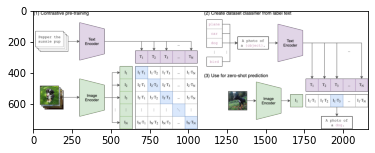

In [62]:
plt.imshow(Image.open("CLIP.png"))

In [13]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000001988CA8AE50>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

#### Предобработка изображений

In [14]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

In [15]:
transforms = T.Compose([
    ScaleMaxSideToSize(CROP_SIZE),
    CropCenter(CROP_SIZE),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])


In [16]:
train_dataset = HatefulMemesDataset(train_path, transforms)
val_dataset = HatefulMemesDataset(dev_path, transforms)

  0%|                                                                                         | 0/1063 [00:00<?, ?it/s]


('its their character not their color that matters', "don't be afraid to love again everyone is not like your ex", 'putting bows on your pet', 'i love everything and everybody! except for squirrels i hate squirrels', 'everybody loves chocolate chip cookies, even hitler', 'go sports! do the thing! win the points!', "fine you're right. now can we fucking drop it?", 'tattoos are bad for your health i know 5 million people that had tattoos and they all died')


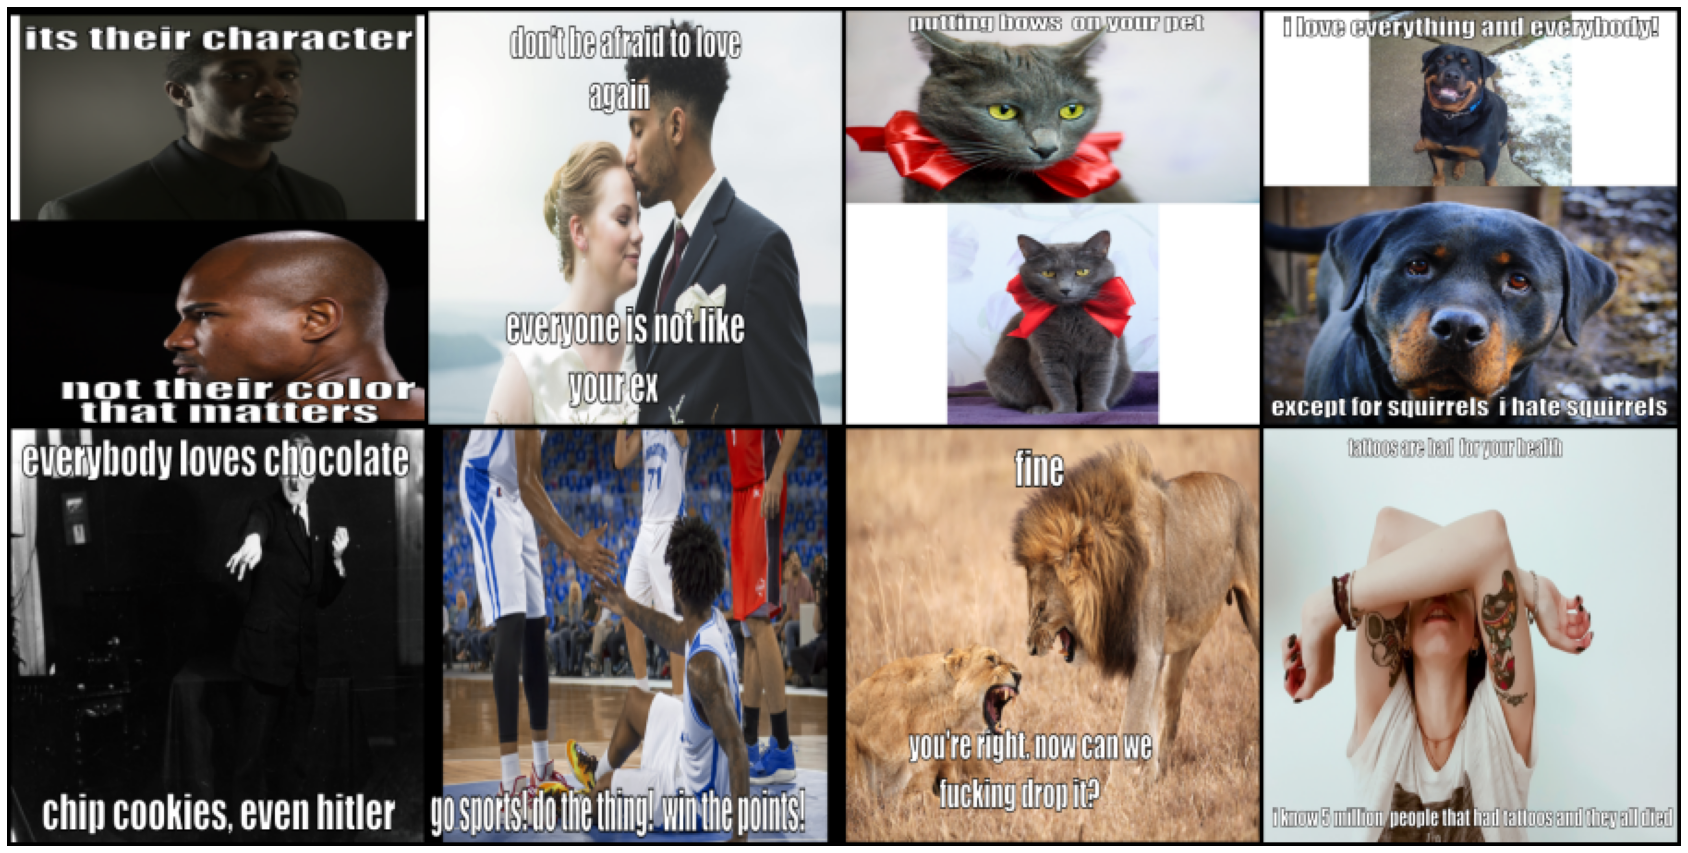

In [18]:
for images, texts, labels, path in tqdm(DataLoader(train_dataset, batch_size=8)):
    #print(images[0].shape, texts[0], labels[0] , labels.shape)
    break
    
grid = torchvision.utils.make_grid([(x * STD[:, None, None] + MEAN[:, None, None]) for x in images], nrow = 4)#
plt.figure(figsize=(30,20)); 
plt.axis(False)
plt.imshow(F.to_pil_image(grid));

print(texts)

#### Извлекаем признаки из текста и картинок

In [19]:
features_train, labels_train = get_features(model, train_dataset)
features_val, labels_val = get_features(model, val_dataset)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


In [20]:
features_train_dataset = FeaturesDataset(features_train, labels_train)
features_val_dataset = FeaturesDataset(features_val, labels_val)

#### Обучение нейросети

In [21]:
input_shape = 1024
num_classes = 2

In [22]:
#torch.manual_seed(0)# 0.666 0.706048
torch.manual_seed(1024) #0.662 0.724256
#torch.manual_seed(567)# 0.658 0.699472
#torch.manual_seed(12) #0.656 0.7045600000000001
#torch.manual_seed(2048) #0.678 0.7083360000000001
#torch.manual_seed(1)# 0.678 0.716224
#torch.manual_seed(215)# 0.656 0.6999199999999999

shape = 256
nn_model = nn.Sequential(
            nn.Linear(input_shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, num_classes),
            )

print(nn_model)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

loss_history, train_history, val_history, best_model_name = train_model(
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 500, scheduler)
print('end!')


Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)
Epoch: 0 lr: 0.010000; Average loss: 0.672309, Train accuracy: 0.635882, Val accuracy: 0.622000
Epoch: 1 lr: 0.010000; Average loss: 0.583438, Train accuracy: 0.691882, Val accuracy: 0.518000
Epoch: 2 lr: 0.010000; Average loss: 0.516564, Train accuracy: 0.743647, Val accuracy: 0.608000
Epoch: 3 lr: 0.010000; Average loss: 0.501129, Train accuracy: 0.749647, Val accuracy: 0.628000
Epoch: 4 lr: 0.010000; Average loss: 0.482486, Train accuracy: 0.768588, Val accuracy: 0.642000
saved classifier_4_0.64

Epoch: 80 lr: 0.001678; Average loss: 0.032988, Train accuracy: 0.987882, Val accuracy: 0.648000
Epoch: 81 lr: 0.001678; Average loss: 0.032061, Train accuracy: 0.987882, Val accuracy: 0.650000
Epoch: 82 lr: 0.001678; Average loss: 0.036055, Train accuracy: 0.987529, Val accuracy: 0.642000
Epoch: 83 lr: 0.001678; Average loss: 0.031282, Train accuracy: 0.989647, Val accuracy: 0.640000
Epoch: 84 lr: 0.001678; Average loss: 0.027409, Train accuracy: 0.990706, Val accuracy: 0.638000
Epoch: 85 lr: 0.001678; Average loss: 0.030779, Train accuracy: 0.990471, Val accuracy: 0.636000
Epoch: 86 lr: 0.001678; Average loss: 0.023062, Train accuracy: 0.992118, Val accuracy: 0.640000
Epoch: 87 lr: 0.001678; Average loss: 0.028763, Train accuracy: 0.989294, Val accuracy: 0.638000
Epoch: 88 lr: 0.001678; Average loss: 0.027556, Train accuracy: 0.990235, Val accuracy: 0.652000
Epoch: 89 lr: 0.001342; Average loss: 0.028670, Train accuracy: 0.989294, Val accuracy: 0.642000
Epoch: 90 lr: 0.001342; Averag

Epoch: 164 lr: 0.000281; Average loss: 0.011392, Train accuracy: 0.996588, Val accuracy: 0.652000
Epoch: 165 lr: 0.000281; Average loss: 0.013901, Train accuracy: 0.995176, Val accuracy: 0.650000
Epoch: 166 lr: 0.000281; Average loss: 0.011295, Train accuracy: 0.995412, Val accuracy: 0.650000
Epoch: 167 lr: 0.000281; Average loss: 0.011380, Train accuracy: 0.995529, Val accuracy: 0.652000
Epoch: 168 lr: 0.000281; Average loss: 0.010296, Train accuracy: 0.996588, Val accuracy: 0.650000
Epoch: 169 lr: 0.000225; Average loss: 0.010577, Train accuracy: 0.996471, Val accuracy: 0.650000
Epoch: 170 lr: 0.000225; Average loss: 0.010079, Train accuracy: 0.996941, Val accuracy: 0.650000
Epoch: 171 lr: 0.000225; Average loss: 0.010735, Train accuracy: 0.996000, Val accuracy: 0.648000
Epoch: 172 lr: 0.000225; Average loss: 0.010974, Train accuracy: 0.996824, Val accuracy: 0.650000
Epoch: 173 lr: 0.000225; Average loss: 0.011700, Train accuracy: 0.996000, Val accuracy: 0.648000
Epoch: 174 lr: 0.000

Epoch: 248 lr: 0.000047; Average loss: 0.012634, Train accuracy: 0.995765, Val accuracy: 0.646000
Epoch: 249 lr: 0.000038; Average loss: 0.011411, Train accuracy: 0.995765, Val accuracy: 0.654000
Epoch: 250 lr: 0.000038; Average loss: 0.011186, Train accuracy: 0.996706, Val accuracy: 0.650000
Epoch: 251 lr: 0.000038; Average loss: 0.010527, Train accuracy: 0.996353, Val accuracy: 0.648000
Epoch: 252 lr: 0.000038; Average loss: 0.009811, Train accuracy: 0.997294, Val accuracy: 0.650000
Epoch: 253 lr: 0.000038; Average loss: 0.007896, Train accuracy: 0.996824, Val accuracy: 0.650000
Epoch: 254 lr: 0.000038; Average loss: 0.009112, Train accuracy: 0.997176, Val accuracy: 0.650000
Epoch: 255 lr: 0.000038; Average loss: 0.009808, Train accuracy: 0.996471, Val accuracy: 0.650000
Epoch: 256 lr: 0.000038; Average loss: 0.010399, Train accuracy: 0.996353, Val accuracy: 0.648000
Epoch: 257 lr: 0.000038; Average loss: 0.009408, Train accuracy: 0.996824, Val accuracy: 0.650000
Epoch: 258 lr: 0.000

Epoch: 332 lr: 0.000006; Average loss: 0.010001, Train accuracy: 0.996471, Val accuracy: 0.652000
Epoch: 333 lr: 0.000006; Average loss: 0.010541, Train accuracy: 0.995765, Val accuracy: 0.650000
Epoch: 334 lr: 0.000006; Average loss: 0.009935, Train accuracy: 0.996588, Val accuracy: 0.650000
Epoch: 335 lr: 0.000006; Average loss: 0.008739, Train accuracy: 0.997176, Val accuracy: 0.650000
Epoch: 336 lr: 0.000006; Average loss: 0.010679, Train accuracy: 0.996471, Val accuracy: 0.650000
Epoch: 337 lr: 0.000006; Average loss: 0.012002, Train accuracy: 0.995412, Val accuracy: 0.650000
Epoch: 338 lr: 0.000006; Average loss: 0.008281, Train accuracy: 0.997176, Val accuracy: 0.650000
Epoch: 339 lr: 0.000005; Average loss: 0.009274, Train accuracy: 0.996706, Val accuracy: 0.650000
Epoch: 340 lr: 0.000005; Average loss: 0.009951, Train accuracy: 0.996353, Val accuracy: 0.650000
Epoch: 341 lr: 0.000005; Average loss: 0.010035, Train accuracy: 0.996471, Val accuracy: 0.650000
Epoch: 342 lr: 0.000

Epoch: 416 lr: 0.000001; Average loss: 0.010330, Train accuracy: 0.996588, Val accuracy: 0.654000
Epoch: 417 lr: 0.000001; Average loss: 0.010938, Train accuracy: 0.995647, Val accuracy: 0.650000
Epoch: 418 lr: 0.000001; Average loss: 0.007665, Train accuracy: 0.998118, Val accuracy: 0.650000
Epoch: 419 lr: 0.000001; Average loss: 0.008496, Train accuracy: 0.997294, Val accuracy: 0.650000
Epoch: 420 lr: 0.000001; Average loss: 0.008415, Train accuracy: 0.997176, Val accuracy: 0.648000
Epoch: 421 lr: 0.000001; Average loss: 0.008059, Train accuracy: 0.997294, Val accuracy: 0.650000
Epoch: 422 lr: 0.000001; Average loss: 0.010550, Train accuracy: 0.996941, Val accuracy: 0.648000
Epoch: 423 lr: 0.000001; Average loss: 0.008761, Train accuracy: 0.997412, Val accuracy: 0.652000
Epoch: 424 lr: 0.000001; Average loss: 0.009624, Train accuracy: 0.997059, Val accuracy: 0.650000
Epoch: 425 lr: 0.000001; Average loss: 0.011189, Train accuracy: 0.996118, Val accuracy: 0.650000
Epoch: 426 lr: 0.000

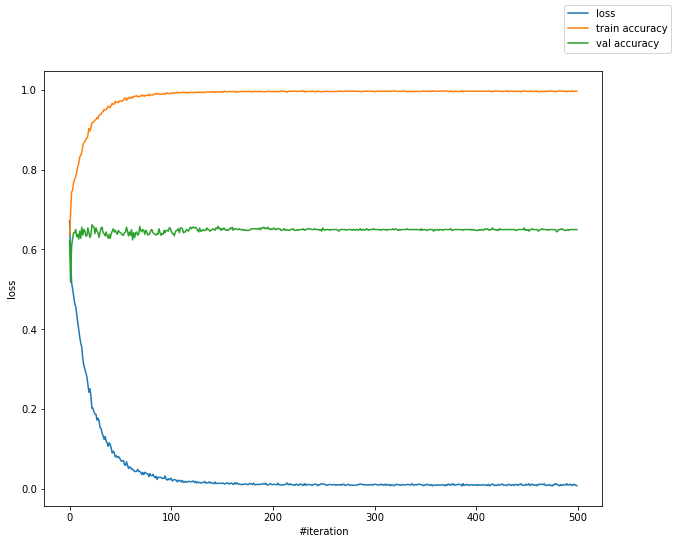

In [23]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, label='loss')
plt.plot(train_history, label='train accuracy')
plt.plot(val_history, label='val accuracy')
fig.legend()
plt.show()

In [24]:
print("best model:", best_model_name)

best model: classifier_22_0.662.ckpt


In [25]:
best_model = torch.load(open(best_model_name, 'rb'))
print(best_model)

Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)


In [26]:
best_model.eval()
for i_step, (x, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x)

acc_score = accuracy_score(np.array([x.item() for x in labels_val]), torch.max(prediction, 1)[1])
auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction[:,1].detach().numpy())
prettyTable.add_row(['Neural Network', acc_score, auc_score])
print(acc_score, auc_score)

0.662 0.724256


0.724256


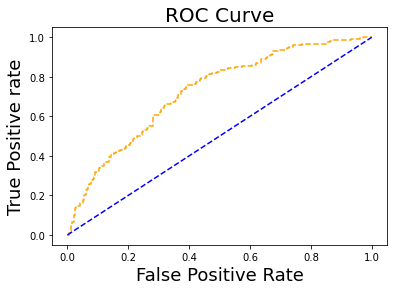

In [27]:
fpr, tpr, thresh = roc_curve(labels_val, prediction[:,1].detach().numpy(), pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction[:,1].detach().numpy())
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

### Попробуем обучить другие модели

In [28]:
X_train = [x.cpu().numpy() for x in features_train]
y_train = [x.item() for x in labels_train]

X_val = [x.cpu().numpy() for x in features_val]
y_val = [x.item() for x in labels_val]

In [29]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

acc_score = accuracy_score(y_val, classifier.predict(X_val))
auc_score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
print(acc_score, auc_score)

0.574 0.652624


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
def objective(trial):
    try:
        penalty = trial.suggest_categorical('penalty', ['l1','l2','elasticnet','none'])
        solver = trial.suggest_categorical('solver', ['newton-cg','lbfgs','liblinear','sag','saga'])
        tol = trial.suggest_float('tol', 1e-6, 1e-1)
        C = trial.suggest_float('C', 1e-6, 10)

        classifier = LogisticRegression(penalty=penalty, solver=solver, tol=tol, C=C, random_state=0)
        classifier.fit(X_train, y_train)
        auc_score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
        return 1 - auc_score
    except Exception as ex:
        print(ex)
        return 1e9

search_space = {"penalty": ['l2', 'none'], "solver": ['newton-cg','lbfgs','liblinear','sag','saga']}
study_lr = optuna.create_study()

study_lr.optimize(objective, n_trials=30)

[I 2022-08-31 21:37:05,227] A new study created in memory with name: no-name-73961688-3025-40ce-828c-9e067c6c630e
[I 2022-08-31 21:37:06,950] Trial 0 finished with value: 0.34774400000000005 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0069535230526546, 'C': 3.046460665521639}. Best is trial 0 with value: 0.34774400000000005.
[I 2022-08-31 21:37:06,952] Trial 1 finished with value: 1000000000.0 and parameters: {'penalty': 'l1', 'solver': 'lbfgs', 'tol': 0.002029589933660175, 'C': 6.845076300786545}. Best is trial 0 with value: 0.34774400000000005.


Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.


[I 2022-08-31 21:37:07,950] Trial 2 finished with value: 0.33451200000000003 and parameters: {'penalty': 'l1', 'solver': 'saga', 'tol': 0.05331862056560071, 'C': 0.5597135446764415}. Best is trial 2 with value: 0.33451200000000003.
[I 2022-08-31 21:37:09,808] Trial 3 finished with value: 0.34366399999999986 and parameters: {'penalty': 'l2', 'solver': 'sag', 'tol': 0.03033869827577206, 'C': 0.41169076358918694}. Best is trial 2 with value: 0.33451200000000003.
[I 2022-08-31 21:37:09,809] Trial 4 finished with value: 1000000000.0 and parameters: {'penalty': 'elasticnet', 'solver': 'lbfgs', 'tol': 0.06977853584703698, 'C': 0.013795054650062435}. Best is trial 2 with value: 0.33451200000000003.
[I 2022-08-31 21:37:09,810] Trial 5 finished with value: 1000000000.0 and parameters: {'penalty': 'elasticnet', 'solver': 'newton-cg', 'tol': 0.0248575557334443, 'C': 8.070554193481986}. Best is trial 2 with value: 0.33451200000000003.


Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.
Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.


[I 2022-08-31 21:37:10,480] Trial 6 finished with value: 0.330464 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.07981323543382987, 'C': 1.0494179145576572}. Best is trial 6 with value: 0.330464.
[I 2022-08-31 21:37:10,482] Trial 7 finished with value: 1000000000.0 and parameters: {'penalty': 'elasticnet', 'solver': 'lbfgs', 'tol': 0.020868843536307448, 'C': 0.9461159912591373}. Best is trial 6 with value: 0.330464.
[I 2022-08-31 21:37:10,483] Trial 8 finished with value: 1000000000.0 and parameters: {'penalty': 'l1', 'solver': 'lbfgs', 'tol': 0.0743552138646783, 'C': 0.1595250697668185}. Best is trial 6 with value: 0.330464.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.
Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.


[I 2022-08-31 21:37:11,120] Trial 9 finished with value: 0.3381600000000001 and parameters: {'penalty': 'none', 'solver': 'saga', 'tol': 0.04525003897819321, 'C': 5.1714035845206645}. Best is trial 6 with value: 0.330464.
[I 2022-08-31 21:37:11,649] Trial 10 finished with value: 0.33392 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.09496779875158845, 'C': 3.114745105770745}. Best is trial 6 with value: 0.330464.
[I 2022-08-31 21:37:12,181] Trial 11 finished with value: 0.33392 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.09772796456543487, 'C': 3.2718853827321213}. Best is trial 6 with value: 0.330464.
[I 2022-08-31 21:37:12,712] Trial 12 finished with value: 0.33392 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.09947968247049048, 'C': 3.2758489421645605}. Best is trial 6 with value: 0.330464.
[I 2022-08-31 21:37:13,385] Trial 13 finished with value: 0.3304480000000001 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 

penalty='none' is not supported for the liblinear solver


[I 2022-08-31 21:37:14,779] Trial 15 finished with value: 0.3471040000000001 and parameters: {'penalty': 'l2', 'solver': 'sag', 'tol': 0.058644768332611744, 'C': 9.976844632454737}. Best is trial 13 with value: 0.3304480000000001.
[I 2022-08-31 21:37:16,563] Trial 16 finished with value: 0.348352 and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.08510880702321792, 'C': 4.691771650429032}. Best is trial 13 with value: 0.3304480000000001.
[I 2022-08-31 21:37:17,440] Trial 17 finished with value: 0.337584 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0642466561978399, 'C': 1.7359157872367108}. Best is trial 13 with value: 0.3304480000000001.
[I 2022-08-31 21:37:17,446] Trial 18 finished with value: 1000000000.0 and parameters: {'penalty': 'none', 'solver': 'liblinear', 'tol': 0.086470338094354, 'C': 4.385112029970938}. Best is trial 13 with value: 0.3304480000000001.


penalty='none' is not supported for the liblinear solver


[I 2022-08-31 21:37:18,630] Trial 19 finished with value: 0.339136 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.03968287933663369, 'C': 1.7685711793779197}. Best is trial 13 with value: 0.3304480000000001.
[I 2022-08-31 21:37:19,416] Trial 20 finished with value: 0.3353440000000001 and parameters: {'penalty': 'l2', 'solver': 'saga', 'tol': 0.08474737074385644, 'C': 5.907304703413114}. Best is trial 13 with value: 0.3304480000000001.
[I 2022-08-31 21:37:19,846] Trial 21 finished with value: 0.333936 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.09116091775857878, 'C': 2.084458132012373}. Best is trial 13 with value: 0.3304480000000001.
[I 2022-08-31 21:37:20,728] Trial 22 finished with value: 0.3378239999999999 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.06946250636495288, 'C': 4.10147398735332}. Best is trial 13 with value: 0.3304480000000001.
[I 2022-08-31 21:37:21,234] Trial 23 finished with value: 0.3304480000000001 and 

Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
penalty='none' is not supported for the liblinear solver
Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


[I 2022-08-31 21:37:23,714] Trial 29 finished with value: 0.33388799999999996 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.09079414347325698, 'C': 1.316642919889839}. Best is trial 13 with value: 0.3304480000000001.


In [32]:
print("Value:", study_lr.best_value)
print("Parameters:", study_lr.best_params)
print("Importance:", optuna.importance.get_param_importances(study_lr))

Value: 0.3304480000000001
Parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.08124303013660714, 'C': 2.1631637257788228}
Importance: OrderedDict([('penalty', 0.5425575393945915), ('solver', 0.4165184210267216), ('C', 0.022279122575513385), ('tol', 0.018644917003173393)])


In [33]:
classifier = LogisticRegression(
    penalty=study_lr.best_params['penalty'],
    solver=study_lr.best_params['solver'],
    tol=study_lr.best_params['tol'],
    C=study_lr.best_params['C'],
    random_state=0)

classifier.fit(X_train, y_train)

acc_score = accuracy_score(y_val, classifier.predict(X_val))
auc_score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
prettyTable.add_row(['Logistic Regression', acc_score, auc_score])
print(acc_score, auc_score)

0.59 0.6695519999999999


In [34]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

acc_score = accuracy_score(y_val, classifier.predict(X_val))
auc_score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
print(acc_score, auc_score)

0.522 0.64216


In [35]:
def objective(trial):
    try:
        criterion = trial.suggest_categorical('criterion', ['gini','entropy','log_loss'])
        max_depth = trial.suggest_categorical('max_depth', [2, 5, 10, 50, 100, None])
       
        classifier = RandomForestClassifier(criterion=criterion, max_depth=max_depth, random_state=0)
        classifier.fit(X_train, y_train)
        auc_score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
        return 1 - auc_score
    except Exception as ex:
        print(ex)
        return 1e9


study_rf = optuna.create_study()

study_rf.optimize(objective, n_trials=30)

[I 2022-08-31 21:37:41,594] A new study created in memory with name: no-name-dd50dc9b-e0c2-4cf4-b755-0326a52d1dd3
[I 2022-08-31 21:37:59,307] Trial 0 finished with value: 0.368 and parameters: {'criterion': 'gini', 'max_depth': 50}. Best is trial 0 with value: 0.368.
[I 2022-08-31 21:38:02,727] Trial 1 finished with value: 0.362368 and parameters: {'criterion': 'gini', 'max_depth': 2}. Best is trial 1 with value: 0.362368.
[I 2022-08-31 21:38:02,773] Trial 2 finished with value: 1000000000.0 and parameters: {'criterion': 'log_loss', 'max_depth': None}. Best is trial 1 with value: 0.362368.


'log_loss'


[I 2022-08-31 21:38:24,793] Trial 3 finished with value: 0.35319200000000006 and parameters: {'criterion': 'entropy', 'max_depth': 100}. Best is trial 3 with value: 0.35319200000000006.
[I 2022-08-31 21:38:24,829] Trial 4 finished with value: 1000000000.0 and parameters: {'criterion': 'log_loss', 'max_depth': 50}. Best is trial 3 with value: 0.35319200000000006.
[I 2022-08-31 21:38:24,875] Trial 5 finished with value: 1000000000.0 and parameters: {'criterion': 'log_loss', 'max_depth': 5}. Best is trial 3 with value: 0.35319200000000006.


'log_loss'
'log_loss'


[I 2022-08-31 21:38:29,390] Trial 6 finished with value: 0.3602080000000001 and parameters: {'criterion': 'entropy', 'max_depth': 2}. Best is trial 3 with value: 0.35319200000000006.
[I 2022-08-31 21:38:52,079] Trial 7 finished with value: 0.35319200000000006 and parameters: {'criterion': 'entropy', 'max_depth': 50}. Best is trial 3 with value: 0.35319200000000006.
[I 2022-08-31 21:38:52,115] Trial 8 finished with value: 1000000000.0 and parameters: {'criterion': 'log_loss', 'max_depth': None}. Best is trial 3 with value: 0.35319200000000006.


'log_loss'


[I 2022-08-31 21:38:55,424] Trial 9 finished with value: 0.362368 and parameters: {'criterion': 'gini', 'max_depth': 2}. Best is trial 3 with value: 0.35319200000000006.
[I 2022-08-31 21:39:17,149] Trial 10 finished with value: 0.35319200000000006 and parameters: {'criterion': 'entropy', 'max_depth': 100}. Best is trial 3 with value: 0.35319200000000006.
[I 2022-08-31 21:39:38,903] Trial 11 finished with value: 0.35319200000000006 and parameters: {'criterion': 'entropy', 'max_depth': None}. Best is trial 3 with value: 0.35319200000000006.
[I 2022-08-31 21:39:56,611] Trial 12 finished with value: 0.3660159999999998 and parameters: {'criterion': 'entropy', 'max_depth': 10}. Best is trial 3 with value: 0.35319200000000006.
[I 2022-08-31 21:40:18,675] Trial 13 finished with value: 0.35319200000000006 and parameters: {'criterion': 'entropy', 'max_depth': None}. Best is trial 3 with value: 0.35319200000000006.
[I 2022-08-31 21:40:40,620] Trial 14 finished with value: 0.35319200000000006 and 

'log_loss'


[I 2022-08-31 21:45:14,481] Trial 28 finished with value: 0.3658079999999999 and parameters: {'criterion': 'gini', 'max_depth': None}. Best is trial 3 with value: 0.35319200000000006.
[I 2022-08-31 21:45:36,360] Trial 29 finished with value: 0.35319200000000006 and parameters: {'criterion': 'entropy', 'max_depth': None}. Best is trial 3 with value: 0.35319200000000006.


In [36]:
print("Value:", study_rf.best_value)
print("Parameters:", study_rf.best_params)
print("Importance:", optuna.importance.get_param_importances(study_rf))

Value: 0.35319200000000006
Parameters: {'criterion': 'entropy', 'max_depth': 100}
Importance: OrderedDict([('criterion', 0.993811270385481), ('max_depth', 0.0061887296145189345)])


In [37]:
classifier = RandomForestClassifier(
    criterion=study_rf.best_params['criterion'],
    max_depth=study_rf.best_params['max_depth'],
    random_state=0)

classifier.fit(X_train, y_train)

acc_score = accuracy_score(y_val, classifier.predict(X_val))
auc_score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
prettyTable.add_row(['Random Forest Classifier', acc_score, auc_score])
print(acc_score, auc_score)

0.522 0.6468079999999999


In [40]:
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)

acc_score = accuracy_score(y_val, classifier.predict(X_val))
auc_score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
print(acc_score, auc_score)

0.564 0.6681119999999999


In [42]:
def objective(trial):
    try:
        loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
        learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1)
        n_estimators = trial.suggest_int('n_estimators', 1, 500, 50)        
        criterion = trial.suggest_categorical('criterion',['friedman_mse', 'squared_error', 'mse'])
        
        classifier = GradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, criterion=criterion)
        classifier.fit(X_train, y_train)
        auc_score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
        return 1 - auc_score
    except Exception as ex:
        print(ex)
        return 1e9

study_gb = optuna.create_study()

study_gb.optimize(objective, n_trials=30)

[I 2022-08-31 22:03:50,562] A new study created in memory with name: no-name-206ddced-16a9-4669-aaf0-d7902d82bf40
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-08-31 22:17:48,073] Trial 0 finished with value: 0.32897599999999994 and parameters: {'loss': 'exponential', 'learning_rate': 0.07018138911472127, 'n_estimators': 401, 'criterion': 'mse'}. Best is trial 0 with value: 0.32897599999999994.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-08-31 22:17:48,092] Trial 1 finished with value: 1000000000.0 and parameters: {'loss': 'deviance', 'learning_rate': 0.05572971089879933, 'n_estimators': 201, 'criterion

'squared_error'


[I 2022-08-31 22:26:21,442] Trial 2 finished with value: 0.32455999999999996 and parameters: {'loss': 'exponential', 'learning_rate': 0.05346197899866105, 'n_estimators': 251, 'criterion': 'friedman_mse'}. Best is trial 2 with value: 0.32455999999999996.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-08-31 22:26:21,461] Trial 3 finished with value: 1000000000.0 and parameters: {'loss': 'log_loss', 'learning_rate': 0.04455989819402731, 'n_estimators': 201, 'criterion': 'friedman_mse'}. Best is trial 2 with value: 0.32455999999999996.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(


Loss 'log_loss' not supported. 


[I 2022-08-31 22:33:15,772] Trial 4 finished with value: 0.3309119999999999 and parameters: {'loss': 'deviance', 'learning_rate': 0.09616447988447478, 'n_estimators': 201, 'criterion': 'friedman_mse'}. Best is trial 2 with value: 0.32455999999999996.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-08-31 22:33:15,790] Trial 5 finished with value: 1000000000.0 and parameters: {'loss': 'log_loss', 'learning_rate': 0.03747314536375099, 'n_estimators': 101, 'criterion': 'friedman_mse'}. Best is trial 2 with value: 0.32455999999999996.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(


Loss 'log_loss' not supported. 


[I 2022-08-31 22:45:27,353] Trial 6 finished with value: 0.34209599999999996 and parameters: {'loss': 'deviance', 'learning_rate': 0.0978863589103184, 'n_estimators': 351, 'criterion': 'friedman_mse'}. Best is trial 2 with value: 0.32455999999999996.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-08-31 22:45:27,370] Trial 7 finished with value: 1000000000.0 and parameters: {'loss': 'log_loss', 'learning_rate': 0.08174504369770709, 'n_estimators': 451, 'criterion': 'squared_error'}. Best is trial 2 with value: 0.32455999999999996.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(


Loss 'log_loss' not supported. 


[I 2022-08-31 22:48:52,451] Trial 8 finished with value: 0.32387199999999994 and parameters: {'loss': 'exponential', 'learning_rate': 0.08234643375502229, 'n_estimators': 101, 'criterion': 'friedman_mse'}. Best is trial 8 with value: 0.32387199999999994.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-08-31 22:53:55,578] Trial 9 finished with value: 0.341024 and parameters: {'loss': 'exponential', 'learning_rate': 0.02013701608230598, 'n_estimators': 151, 'criterion': 'friedman_mse'}. Best is trial 8 with value: 0.32387199999999994.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-08-31 22:53:57,617] Trial 10 

'squared_error'


[I 2022-08-31 23:27:14,556] Trial 16 finished with value: 0.4093279999999999 and parameters: {'loss': 'exponential', 'learning_rate': 0.029094866438870038, 'n_estimators': 1, 'criterion': 'friedman_mse'}. Best is trial 13 with value: 0.32304.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-08-31 23:30:41,374] Trial 17 finished with value: 0.32620800000000005 and parameters: {'loss': 'exponential', 'learning_rate': 0.08406818123954583, 'n_estimators': 101, 'criterion': 'friedman_mse'}. Best is trial 13 with value: 0.32304.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-08-31 23:30:41,396] Trial 18 finished wi

Loss 'log_loss' not supported. 
'squared_error'


[I 2022-08-31 23:44:24,106] Trial 20 finished with value: 0.3295840000000001 and parameters: {'loss': 'exponential', 'learning_rate': 0.044796839931532335, 'n_estimators': 401, 'criterion': 'friedman_mse'}. Best is trial 13 with value: 0.32304.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-08-31 23:52:58,186] Trial 21 finished with value: 0.32598399999999994 and parameters: {'loss': 'exponential', 'learning_rate': 0.05538746792766477, 'n_estimators': 251, 'criterion': 'friedman_mse'}. Best is trial 13 with value: 0.32304.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-09-01 00:01:29,845] Trial 22 finished 

Loss 'log_loss' not supported. 


[I 2022-09-01 00:55:52,691] Trial 29 finished with value: 0.32966399999999996 and parameters: {'loss': 'exponential', 'learning_rate': 0.07162088073512668, 'n_estimators': 401, 'criterion': 'friedman_mse'}. Best is trial 13 with value: 0.32304.


In [43]:
print("Value:", study_gb.best_value)
print("Parameters:", study_gb.best_params)
print("Importance:", optuna.importance.get_param_importances(study_gb))

Value: 0.32304
Parameters: {'loss': 'exponential', 'learning_rate': 0.03150476928196415, 'n_estimators': 301, 'criterion': 'friedman_mse'}
Importance: OrderedDict([('loss', 0.5519942502033417), ('criterion', 0.37486928569305605), ('learning_rate', 0.05205105649528789), ('n_estimators', 0.021085407608314465)])


In [44]:
classifier = GradientBoostingClassifier(
    loss=study_gb.best_params['loss'],
    learning_rate=study_gb.best_params['learning_rate'],
    n_estimators=study_gb.best_params['n_estimators'],
    criterion=study_gb.best_params['criterion'],
    random_state=0)

classifier.fit(X_train, y_train)

acc_score = accuracy_score(y_val, classifier.predict(X_val))
auc_score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
prettyTable.add_row(['Gradient Boosting Classifier', acc_score, auc_score])
print(acc_score, auc_score)

0.566 0.6768


In [45]:
classifier = AdaBoostClassifier()
classifier.fit(X_train, y_train)

acc_score = accuracy_score(y_val, classifier.predict(X_val))
auc_score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
print(acc_score, auc_score)

0.55 0.605456


In [56]:
def objective(trial):
    try:
        est = trial.suggest_categorical('base_estimator',[
            'DecisionTreeClassifier',
            'LogisticRegression',
            'RandomForestClassifier',
            ])#   'GradientBoostingClassifier' 
        
        if est == 'DecisionTreeClassifier': base_estimator = DecisionTreeClassifier()
        elif est == 'LogisticRegression': base_estimator = LogisticRegression()
        elif est == 'RandomForestClassifier': base_estimator = RandomForestClassifier()
        elif est == 'GradientBoostingClassifier': base_estimator = GradientBoostingClassifier()
        elif est == 'AdaBoostClassifier': base_estimator = AdaBoostClassifier()
            
        learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1)
        n_estimators = trial.suggest_int('n_estimators', 1, 500, 50)      

        classifier = AdaBoostClassifier(base_estimator=base_estimator, learning_rate=learning_rate, n_estimators=n_estimators, random_state=0)
        classifier.fit(X_train, y_train)
        auc_score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
        return 1 - auc_score
    except Exception as ex:
        print(ex)
        return 1e9

study_ada = optuna.create_study()

study_ada.optimize(objective, n_trials=30)

[I 2022-09-01 11:01:23,594] A new study created in memory with name: no-name-6071b5dc-35dd-40a1-89b3-26844b3c8d84
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-09-01 11:02:16,538] Trial 0 finished with value: 0.3311200000000001 and parameters: {'base_estimator': 'LogisticRegression', 'learning_rate': 0.07498064561018959, 'n_estimators': 401}. Best is trial 0 with value: 0.3311200000000001.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-09-01 11:02:59,111] Trial 1 finished with value: 0.33787200000000006 and parameters: {'base_estimator': 'LogisticRegression', 'learning_rate': 0.042306246071879584, 'n_estim

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-09-01 11:11:14,184] Trial 17 finished with value: 0.3297120000000001 and parameters: {'base_estimator': 'LogisticRegression', 'learning_rate': 0.08410314615462776, 'n_estimators': 451}. Best is trial 14 with value: 0.3291679999999999.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [1, 451].
  warnings.warn(
[I 2022-09-01 11:11:50,442] Trial 18 finished with value: 0.3354719999999999 and parameters: {'base_estimator': 'LogisticRegression', 'learning_rate': 0.06571866315707543, 'n_estimators': 251}. Best is trial 14 with value: 0.3291679999999999.
C:\ProgramData\Anaconda3\lib\site-packages\optuna\

In [57]:
print("Value:", study_ada.best_value)
print("Parameters:", study_ada.best_params)
print("Importance:", optuna.importance.get_param_importances(study_ada))

Value: 0.32910399999999995
Parameters: {'base_estimator': 'LogisticRegression', 'learning_rate': 0.0997450248721673, 'n_estimators': 451}
Importance: OrderedDict([('base_estimator', 0.9690336934805427), ('learning_rate', 0.030200710193011755), ('n_estimators', 0.000765596326445614)])


In [60]:
est = study_ada.best_params['base_estimator']

if est == 'DecisionTreeClassifier': base_estimator = DecisionTreeClassifier()
elif est == 'LogisticRegression': base_estimator = LogisticRegression()
elif est == 'RandomForestClassifier': base_estimator = RandomForestClassifier()
elif est == 'GradientBoostingClassifier': base_estimator = GradientBoostingClassifier()
elif est == 'AdaBoostClassifier': base_estimator = AdaBoostClassifier()
            
classifier = AdaBoostClassifier(
    base_estimator=base_estimator,
    learning_rate=study_ada.best_params['learning_rate'],
    n_estimators=study_ada.best_params['n_estimators'],
    random_state=0)

classifier.fit(X_train, y_train)

acc_score = accuracy_score(y_val, classifier.predict(X_val))
auc_score = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
prettyTable.add_row(['AdaBoost Classifier', acc_score, auc_score])
print(acc_score, auc_score)

0.578 0.670896


## Результаты предсказаний с использованием различных классификаторов

In [61]:
print(prettyTable)

+------------------------------+----------+--------------------+
|          Model name          | Accuracy |      ROC AUC       |
+------------------------------+----------+--------------------+
|        Neural Network        |  0.662   |      0.724256      |
|     Logistic Regression      |   0.59   | 0.6695519999999999 |
|   Random Forest Classifier   |  0.522   | 0.6468079999999999 |
| Gradient Boosting Classifier |  0.566   |       0.6768       |
|     AdaBoost Classifier      |  0.578   |      0.670896      |
+------------------------------+----------+--------------------+


#### При использовании нейросети в качестве классификатора получается самое высокое качество предсказания